Table of contents
1. [Census Data: Demographic & Shapefile](#census)
2. [Precinct Shapefile](#shapefile)
3. [Legislative Boundaries](#legislative)
4. [Election Results](#electionresults)
5. [Joining Election Results to Precinct Shapefile](#joining)
6. [Comparison to MGGG](#comparison)

**Import Python Packages**

In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geopandas as gp
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

<a name="census"></a>

# Census Data: Demographic & Shapefile

The functions below retrieve block level data for a state using the state fips code from census API, then retrieves data from appropriate
columns in GEOID, convert to .csv to easily manipulate individual state data

In [31]:
#code chunk by Melisande Teng 

variables = [
    # pop
    "P001001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]


def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [32]:
# Specify MI code to pull demographic data at block level
blocks_2010_demo = block_data_for_state('26')
blocks_2010_demo.to_csv('./raw-from-source/mi_demo_census_2010_blocks.csv', index = False)
# Now we have the block data by county 

Output the block data to a csv so that you can read it in and not have to query from the API every time to re-run. 

In [33]:
blocks_2010_demo = pd.read_csv('./raw-from-source/mi_demo_census_2010_blocks.csv')
blocks_2010_demo = blocks_2010_demo.astype({"geoid": str})
blocks_2010_demo.head(2)

,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,geoid
0,16,13,0,0,3,0,0,0,0,0,...,3,0,0,0,"Block 1028, Block Group 1, Census Tract 4001, ...",26,161,400100,1028,261614001001028
1,279,188,20,0,41,0,2,9,19,15,...,41,0,2,9,"Block 1000, Block Group 1, Census Tract 4001, ...",26,161,400100,1000,261614001001000


**Read in 2010 Census Block TIGER/LINE shapefile**

In [34]:
#Read Census block shapefiles
#Source: (https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Blocks)
blocks_2010_shp = gpd.read_file("./raw-from-source/tl_2010_26_tabblock10/tl_2010_26_tabblock10.shp")

In [35]:
len(blocks_2010_shp)

329885

In [36]:
len(blocks_2010_demo)

329885

Counts are the same so the join between the block demo and block shapefile should be good!

## Join Block-Level Census Data
**Join data with shape (block level demographic data with block level shapefile)**

In [37]:
demographic_block = blocks_2010_shp.merge(blocks_2010_demo, how = 'inner', left_on = 'GEOID10', right_on = 'geoid', indicator = True)

Run some checks to make sure all looks good. 

In [38]:
demographic_block.sample(3)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,...,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,geoid,_merge
212500,26,125,123100,2020,261251231002020,Block 2020,G5040,R,None,None,...,0,0,0,"Block 2020, Block Group 2, Census Tract 1231, ...",26,125,123100,2020,261251231002020,both
88576,26,059,051000,2016,260590510002016,Block 2016,G5040,U,38998,C,...,0,0,0,"Block 2016, Block Group 2, Census Tract 510, H...",26,59,51000,2016,260590510002016,both
251834,26,141,950300,2225,261419503002225,Block 2225,G5040,R,None,None,...,0,0,0,"Block 2225, Block Group 2, Census Tract 9503, ...",26,141,950300,2225,261419503002225,both


In [39]:
print(len(demographic_block.GEOID10))
print(len(blocks_2010_shp.GEOID10))
print(demographic_block.TOTPOP.sum())
print(blocks_2010_demo.TOTPOP.sum())

329885
329885
9883640
9883640


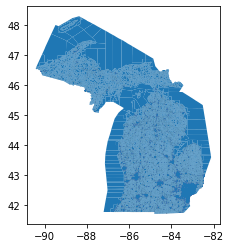

In [40]:
demographic_block.plot()

<a name="shapefile"></a>

# Precinct Shapefile
Prorate demographic and Voting Population data from census block level to precinct level

In [41]:
#2016 PRECINCTS
precincts = gpd.read_file("./raw-from-source/2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")

In [42]:
precincts.shape

(4810, 10)

## MGGG Final File
To compare as we go

In [43]:
#Final MGGG Shapefile
mggg_final_shp = gpd.read_file("./raw-from-source/MI_precincts_upd_20210218/MI.shp")

In [44]:
mggg_final_shp.shape

(4809, 46)

There's one more precinct in the file we have from the Michigan Data Portal than in MGGG's file. 

## Assign Block-Level Census Data to Precincts
**Demographic and Voting Pop Data from Block Level to Precinct Level**

In [45]:
precincts.crs

<Projected CRS: EPSG:3078>
Name: NAD83 / Michigan Oblique Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Michigan
- bounds: (-90.42, 41.69, -82.13, 48.32)
Coordinate Operation:
- name: Michigan Oblique Mercator (meters)
- method: Hotine Oblique Mercator (variant A)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [46]:
proj = precincts.crs
precincts = precincts.to_crs(proj)
demographic_block = demographic_block.to_crs(proj)

In [47]:
demographic_block.columns = demographic_block.columns.str.strip()

In [48]:
precincts.head(1)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."


See what columns are in MGGG's file and not in ours that we will have to add. 

In [49]:
set(mggg_final_shp.columns) - set(demographic_block.columns)

{'CD',
 'CountyFips',
 'ElectionYe',
 'HDIST',
 'Jurisdicti',
 'Label',
 'PRES16D',
 'PRES16G',
 'PRES16L',
 'PRES16R',
 'SENDIST',
 'ShapeSTLen',
 'VTD',
 'VTD2016_x',
 'county_fip',
 'county_lat',
 'county_lon',
 'county_nam',
 'jurisdic_1',
 'precinct'}

In [50]:
precincts['geometry'] = precincts.buffer(0)

In [51]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

demo_variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

demographic_precinct = maup.assign(demographic_block, precincts)

In [52]:
precincts[demo_variables] = demographic_block[demo_variables].groupby(demographic_precinct).sum()

In [53]:
precincts.head(2)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HISP,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,57,1572,38,1330,75,2,20,0,6,101
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,57,1992,43,1760,41,3,16,0,1,128


In [54]:
precincts.TOTPOP.sum()

9883640

Comparing to mggg's race fields

In [55]:
mggg_final_shp = mggg_final_shp.to_crs(proj)

In [56]:
mggg_final_shp.NH_WHITE.sum()

7569939

In [57]:
mggg_final_shp.TOTPOP.sum()

9883640

Looks good, MGGG fixed their total population issue

<a name="legislative"></a>

# Legislative Boundaries

## Assign the state senate districts

In [58]:
senate_districts = gp.read_file("./raw-from-source/tl_2013_26_sldu/tl_2013_26_sldu.shp")

In [59]:
senate_districts = senate_districts.to_crs(proj)

In [60]:
senate_districts.sample(3)

,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
29,26,030,26030,State Senate District 30,LU,2013,G5210,N,1459605745,2765726306,+43.0568042,-086.2480756,"POLYGON ((409731.865 285818.120, 414104.991 28..."
20,26,021,26021,State Senate District 21,LU,2013,G5210,N,4036344511,2725649414,+41.9685650,-086.3232368,"POLYGON ((399603.427 135741.141, 399618.592 13..."
27,26,028,26028,State Senate District 28,LU,2013,G5210,N,1431224566,47359022,+43.1066447,-085.5686068,"POLYGON ((516866.232 294920.759, 516868.961 29..."


In [61]:
senate_districts.set_index('SLDUST', inplace = True)

In [62]:
senate_districts.sort_index(inplace = True)

In [63]:
senate_districts.head(3)

,STATEFP,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
SLDUST,,,,,,,,,,,,
001,26,26001,State Senate District 1,LU,2013,G5210,N,209597156,45849849,+42.1634314,-083.1822438,"POLYGON ((725902.683 178533.209, 725927.637 17..."
002,26,26002,State Senate District 2,LU,2013,G5210,N,123604372,77486341,+42.4443980,-082.8736621,"POLYGON ((735683.666 201915.723, 735706.499 20..."
003,26,26003,State Senate District 3,LU,2013,G5210,N,142128270,827148,+42.3446638,-083.2098765,"POLYGON ((723001.611 212320.956, 723012.629 21..."


In [64]:
precincts.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HISP,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,57,1572,38,1330,75,2,20,0,6,101
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,57,1992,43,1760,41,3,16,0,1,128
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,64,2283,48,2024,43,2,30,1,3,132


In [65]:
assignments = maup.assign(precincts, senate_districts)

In [66]:
assignments

0       003
1       003
2       003
3       003
4       003
       ... 
4805    022
4806    022
4807    022
4808    022
4809    022
Length: 4810, dtype: object

In [67]:
assignments.unique()

array(['003', '036', '038', '026', '037', '019', '031', '035', '021',
       '016', '033', '024', '032', '014', '027', '025', '023', '020',
       '029', '028', '017', '022', '008', '009', '010', '034', '030',
       '018', '004', '006', '001', '007', '005', '002', '012', '013',
       '015', '011'], dtype=object)

In [68]:
# Assign the CDs to the precincts shapefile
precincts["SEN_DIST"] = assignments

In [69]:
# Confirm what it looks like and that the SD assignment is correct by looking up some counties
precincts.sample()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST
4403,4404,2746,1253742000003,125,37420,2016,City of Hazel Park,3.237659e+06,8411.164216,"POLYGON ((739643.521 215822.634, 739645.135 21...",...,3013,52,2560,226,26,45,1,0,103,011


In [70]:
precincts.loc[precincts['VTD2016'] == '0050126000001']

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST
69,70,24,0050126000001,005,01260,2016,City of Allegan,1.520515e+07,27763.275509,"POLYGON ((513778.494 222001.410, 513410.908 22...",...,2557,83,2328,84,16,19,0,1,26,026


Checked 5 random precincts in different senate districts and they all spot checked correctly. Now compare to MGGG's senate districts:

In [71]:
overlap = precincts.merge(mggg_final_shp, how = 'left', left_on = 'VTD2016', right_on = 'VTD2016_x')

In [72]:
overlap.head(1)

,OBJECTID,Id,VTD2016,CountyFips_x,Jurisdicti_x,ElectionYe_x,Label_x,ShapeSTAre,ShapeSTLen_x,geometry_x,...,WVAP_y,BVAP_y,AMINVAP_y,ASIANVAP_y,NHPIVAP_y,OTHERVAP_y,2MOREVAP_y,NH_2MORE_y,H_2MORE,geometry_y
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,1330.0,75.0,2.0,20.0,0.0,6.0,101.0,172.0,7.0,"POLYGON ((734740.167 203393.092, 734728.833 20..."


In [73]:
overlap.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips_x', 'Jurisdicti_x',
       'ElectionYe_x', 'Label_x', 'ShapeSTAre', 'ShapeSTLen_x', 'geometry_x',
       'TOTPOP_x', 'NH_WHITE_x', 'NH_BLACK_x', 'NH_AMIN_x', 'NH_ASIAN_x',
       'NH_NHPI_x', 'NH_OTHER_x', 'NH_2MORE_x', 'HISP_x', 'VAP_x', 'HVAP_x',
       'WVAP_x', 'BVAP_x', 'AMINVAP_x', 'ASIANVAP_x', 'NHPIVAP_x',
       'OTHERVAP_x', '2MOREVAP_x', 'SEN_DIST', 'VTD2016_x', 'ShapeSTLen_y',
       'CountyFips_y', 'Jurisdicti_y', 'ElectionYe_y', 'Label_y', 'VTD',
       'county_nam', 'county_fip', 'county_lat', 'county_lon', 'jurisdic_1',
       'precinct', 'PRES16D', 'PRES16R', 'PRES16L', 'PRES16G', 'HDIST',
       'SENDIST', 'CD', 'TOTPOP_y', 'NH_WHITE_y', 'NH_BLACK_y', 'NH_AMIN_y',
       'NH_ASIAN_y', 'NH_NHPI_y', 'NH_OTHER_y', 'HISP_y', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'VAP_y', 'HVAP_y', 'WVAP_y',
       'BVAP_y', 'AMINVAP_y', 'ASIANVAP_y', 'NHPIVAP_y', 'OTHERVAP_y',
       '2MOREVAP_y', 'NH_2MORE_y

In [74]:
overlap[['SEN_DIST', 'SENDIST']].assign(NOTEQUAL=overlap.SEN_DIST != overlap.SENDIST)['NOTEQUAL'].sum()

1

In [75]:
ne = overlap[['VTD2016','Label_x','SEN_DIST', 'SENDIST']].assign(NOTEQUAL=overlap.SEN_DIST != overlap.SENDIST)
ne.loc[ne['NOTEQUAL'] == True]


,VTD2016,Label_x,SEN_DIST,SENDIST,NOTEQUAL
747,0492900005062,City of Flint,027,NaN,True


The 2013 TIGER file matches almost perfectly to MGGG's, except for with one precinct which is missing a state senate assignment in MGGG's file. 

## Assign the state house districts

In [76]:
house_districts = gp.read_file("./raw-from-source/tl_2013_26_sldl/tl_2013_26_sldl.shp")

In [77]:
house_districts = house_districts.to_crs(proj)

In [78]:
house_districts.sample(3)

,STATEFP,SLDLST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
21,26,022,26022,State House District 22,LL,2013,G5220,N,49938362,78905,+42.4963780,-082.9611457,"POLYGON ((745069.081 219376.061, 745069.083 21..."
19,26,020,26020,State House District 20,LL,2013,G5220,N,112607426,1304706,+42.3800821,-083.4842012,"POLYGON ((701225.912 212382.754, 701465.082 21..."
32,26,033,26033,State House District 33,LL,2013,G5220,N,476122931,1572092,+42.7843977,-082.8720256,"POLYGON ((746109.028 264805.762, 746708.409 26..."


In [79]:
house_districts.set_index('SLDLST', inplace = True)

In [80]:
house_districts.sort_index(inplace = True)

In [81]:
house_districts.head(3)

,STATEFP,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
SLDLST,,,,,,,,,,,,
001,26,26001,State House District 1,LL,2013,G5220,N,37366542,45575754,+42.4443980,-082.8736621,"POLYGON ((747286.322 211325.648, 747309.318 21..."
002,26,26002,State House District 2,LL,2013,G5220,N,50263116,31884179,+42.3846252,-082.9200786,"POLYGON ((745386.371 207053.873, 745421.709 20..."
003,26,26003,State House District 3,LL,2013,G5220,N,44510217,20627,+42.4322737,-083.0581649,"POLYGON ((734881.485 214680.435, 734884.358 21..."


In [82]:
assignments = maup.assign(precincts, house_districts)

In [83]:
assignments

0       015
1       015
2       009
3       015
4       009
       ... 
4805    042
4806    047
4807    047
4808    047
4809    047
Length: 4810, dtype: object

In [84]:
assignments.unique()

array(['015', '009', '106', '109', '080', '072', '105', '097', '110',
       '087', '098', '096', '101', '079', '078', '058', '062', '063',
       '059', '107', '093', '103', '108', '071', '065', '051', '050',
       '048', '034', '049', '104', '070', '084', '067', '069', '068',
       '086', '099', '064', '066', '060', '061', '074', '077', '073',
       '075', '076', '100', '082', '057', '042', '047', '033', '036',
       '028', '032', '024', '031', '018', '022', '030', '025', '102',
       '017', '056', '091', '092', '088', '089', '090', '094', '085',
       '095', '081', '083', '053', '055', '052', '054', '013', '021',
       '023', '020', '011', '007', '008', '010', '003', '001', '004',
       '002', '006', '005', '014', '019', '012', '016', '046', '029',
       '027', '040', '041', '039', '037', '044', '043', '035', '038',
       '026', '045'], dtype=object)

In [85]:
# Assign the CDs to the precincts shapefile
precincts["H_DIST"] = assignments

In [86]:
# Confirm what it looks like and that the HD assignment is correct by looking up some counties
precincts.sample()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST
3924,3925,4511,1633628000007,163,36280,2016,City of Hamtramck,2.550662e+06,9033.549594,"POLYGON ((743257.161 209561.692, 743262.383 20...",...,55,1359,505,5,203,0,4,107,002,004


In [87]:
precincts.loc[precincts['VTD2016'] == '0050126000001']

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST
69,70,24,0050126000001,005,01260,2016,City of Allegan,1.520515e+07,27763.275509,"POLYGON ((513778.494 222001.410, 513410.908 22...",...,83,2328,84,16,19,0,1,26,026,080


Checked 5 random precincts in different senate districts and they all spot checked correctly. Now compare to MGGG's house districts:

In [88]:
overlap = precincts.merge(mggg_final_shp, how = 'left', left_on = 'VTD2016', right_on = 'VTD2016_x')

In [89]:
overlap.head(1)

,OBJECTID,Id,VTD2016,CountyFips_x,Jurisdicti_x,ElectionYe_x,Label_x,ShapeSTAre,ShapeSTLen_x,geometry_x,...,WVAP_y,BVAP_y,AMINVAP_y,ASIANVAP_y,NHPIVAP_y,OTHERVAP_y,2MOREVAP_y,NH_2MORE_y,H_2MORE,geometry_y
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,1330.0,75.0,2.0,20.0,0.0,6.0,101.0,172.0,7.0,"POLYGON ((734740.167 203393.092, 734728.833 20..."


In [90]:
overlap.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips_x', 'Jurisdicti_x',
       'ElectionYe_x', 'Label_x', 'ShapeSTAre', 'ShapeSTLen_x', 'geometry_x',
       'TOTPOP_x', 'NH_WHITE_x', 'NH_BLACK_x', 'NH_AMIN_x', 'NH_ASIAN_x',
       'NH_NHPI_x', 'NH_OTHER_x', 'NH_2MORE_x', 'HISP_x', 'VAP_x', 'HVAP_x',
       'WVAP_x', 'BVAP_x', 'AMINVAP_x', 'ASIANVAP_x', 'NHPIVAP_x',
       'OTHERVAP_x', '2MOREVAP_x', 'SEN_DIST', 'H_DIST', 'VTD2016_x',
       'ShapeSTLen_y', 'CountyFips_y', 'Jurisdicti_y', 'ElectionYe_y',
       'Label_y', 'VTD', 'county_nam', 'county_fip', 'county_lat',
       'county_lon', 'jurisdic_1', 'precinct', 'PRES16D', 'PRES16R', 'PRES16L',
       'PRES16G', 'HDIST', 'SENDIST', 'CD', 'TOTPOP_y', 'NH_WHITE_y',
       'NH_BLACK_y', 'NH_AMIN_y', 'NH_ASIAN_y', 'NH_NHPI_y', 'NH_OTHER_y',
       'HISP_y', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'VAP_y', 'HVAP_y', 'WVAP_y', 'BVAP_y', 'AMINVAP_y',
       'ASIANVAP_y', 'NHPIVAP_y', 'OTHERVAP_y', '2MOREVAP_y', '

In [91]:
overlap[['H_DIST', 'HDIST']].assign(NOTEQUAL=overlap.H_DIST != overlap.HDIST)['NOTEQUAL'].sum()

1

In [92]:
ne = overlap[['VTD2016','Label_x','H_DIST', 'HDIST']].assign(NOTEQUAL=overlap.H_DIST != overlap.HDIST)
ne.loc[ne['NOTEQUAL'] == True]


,VTD2016,Label_x,H_DIST,HDIST,NOTEQUAL
747,0492900005062,City of Flint,034,NaN,True


MGGG is missing one house district as well but they all match.

## Assign the congressional districts

In [94]:
congressional_districts = gp.read_file("./raw-from-source/tl_2013_us_cd113/tl_2013_us_cd113.shp")

Filtering to MI from national CD file. There are 15 rows because one is 'undefined CD' for water area in MI. 

In [95]:
congressional_districts = congressional_districts.loc[congressional_districts['STATEFP'] == '26']

In [96]:
congressional_districts = congressional_districts.to_crs(proj)

In [97]:
congressional_districts.sample(3)

,STATEFP,CD113FP,GEOID,NAMELSAD,LSAD,CDSESSN,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
236,26,08,2608,Congressional District 8,C2,113,G5200,N,3893099815,99752538,+42.6477730,-083.9453541,"POLYGON ((614295.986 239125.343, 614294.813 23..."
231,26,13,2613,Congressional District 13,C2,113,G5200,N,478798047,5412343,+42.3803814,-083.3125530,"POLYGON ((711528.216 203504.883, 711592.862 20..."
232,26,ZZ,26ZZ,Congressional Districts not defined,00,113,G5200,F,0,4875242977,+42.6363171,-086.5447420,"MULTIPOLYGON (((756864.193 221274.686, 756867...."


In [98]:
congressional_districts.set_index('CD113FP', inplace = True)

In [99]:
congressional_districts.sort_index(inplace = True)

In [100]:
congressional_districts.head(3)

,STATEFP,GEOID,NAMELSAD,LSAD,CDSESSN,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
CD113FP,,,,,,,,,,,,
01,26,2601,Congressional District 1,C2,113,G5200,N,64823252734,75783538092,+46.1573045,-086.4369120,"POLYGON ((161317.933 677736.734, 161486.135 67..."
02,26,2602,Congressional District 2,C2,113,G5200,N,8507341869,7462277226,+43.3975406,-086.3188626,"POLYGON ((406913.197 314922.337, 407532.411 32..."
03,26,2603,Congressional District 3,C2,113,G5200,N,6810385641,177862152,+42.7200275,-085.2372759,"POLYGON ((516866.232 294920.759, 516868.961 29..."


In [101]:
assignments = maup.assign(precincts, congressional_districts)

In [102]:
assignments

0       12
1       12
2       12
3       12
4       12
        ..
4805    08
4806    08
4807    08
4808    08
4809    08
Length: 4810, dtype: object

In [103]:
assignments.unique()

array(['12', '01', '06', '02', '05', '03', '07', '04', '10', '08', '09',
       '11', '13', '14'], dtype=object)

In [104]:
# Assign the CDs to the precincts shapefile
precincts["CONGRESSIONAL_DISTRICTS"] = assignments

In [105]:
# Confirm what it looks like and that the HD assignment is correct by looking up some counties
precincts.sample()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST,CONGRESSIONAL_DISTRICTS
2125,2126,2126,0997646000014,099,76460,2016,City of Sterling Heights,2.039347e+06,6689.811936,"POLYGON ((740387.146 227432.969, 740393.602 22...",...,1782,182,4,235,0,5,58,010,030,09


In [106]:
overlap = precincts.merge(mggg_final_shp, how = 'left', left_on = 'VTD2016', right_on = 'VTD2016_x')

In [107]:
overlap.head(1)

,OBJECTID,Id,VTD2016,CountyFips_x,Jurisdicti_x,ElectionYe_x,Label_x,ShapeSTAre,ShapeSTLen_x,geometry_x,...,WVAP_y,BVAP_y,AMINVAP_y,ASIANVAP_y,NHPIVAP_y,OTHERVAP_y,2MOREVAP_y,NH_2MORE_y,H_2MORE,geometry_y
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,1330.0,75.0,2.0,20.0,0.0,6.0,101.0,172.0,7.0,"POLYGON ((734740.167 203393.092, 734728.833 20..."


In [108]:
overlap[['CONGRESSIONAL_DISTRICTS', 'CD']].assign(NOTEQUAL=overlap.CONGRESSIONAL_DISTRICTS != overlap.CD)['NOTEQUAL'].sum()

1

In [109]:
ne = overlap[['VTD2016','Label_x','H_DIST', 'HDIST']].assign(NOTEQUAL=overlap.CONGRESSIONAL_DISTRICTS != overlap.CD)
ne.loc[ne['NOTEQUAL'] == True]


,VTD2016,Label_x,H_DIST,HDIST,NOTEQUAL
747,0492900005062,City of Flint,034,NaN,True


<a name="electionresults"></a>

# Election Results
Only for 2016 Presidential election

## Reading in 2016 Presidential Results

In [110]:
#2016 precinct-level election data - all offices all states
precinct_election_data = pd.read_csv("./raw-from-source/2016-precinct-president.csv", 
                                     encoding='ISO-8859-1',
                                     dtype = {"county_name" : "str","precinct" : "str","district" : "str", "county_fips": "str"},
                                    low_memory=False)
#specified datatype for specific columns due to error message

In [111]:
precinct_election_data.head(3)

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001,161526.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN


Filter to only MI results, because MEDSL election results are national

In [112]:
mi_precinct_election = precinct_election_data[precinct_election_data.state_fips == 26]

In [113]:
mi_precinct_election.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [114]:
mi_precinct_election['county_fips'].unique()

array(['26001', '26003', '26005', '26007', '26009', '26011', '26013',
       '26015', '26017', '26019', '26021', '26023', '26025', '26027',
       '26029', '26031', '26033', '26035', '26037', '26039', '26041',
       '26043', '26045', '26047', '26049', '26051', '26053', '26055',
       '26057', '26059', '26061', '26063', '26065', '26067', '26069',
       '26071', '26073', '26075', '26077', '26079', '26081', '26083',
       '26085', '26087', '26089', '26091', '26093', '26095', '26097',
       '26099', '26101', '26103', '26105', '26107', '26109', '26111',
       '26113', '26115', '26117', '26119', '26121', '26123', '26125',
       '26127', '26129', '26131', '26133', '26135', '26137', '26139',
       '26141', '26143', '26145', '26151', '26153', '26155', '26147',
       '26149', '26157', '26159', '26161', '26163', '26165'], dtype=object)

Testing out dataset, investigating

In [115]:
mi_precinct_election['precinct']

1058001          HAWES TOWNSHIP; 1
1058002          HAWES TOWNSHIP; 1
1058003          HAWES TOWNSHIP; 1
1058004          HAWES TOWNSHIP; 1
1058005          HAWES TOWNSHIP; 1
                    ...           
1123997    SPRINGVILLE TOWNSHIP; 1
1123998    SPRINGVILLE TOWNSHIP; 1
1123999    SPRINGVILLE TOWNSHIP; 1
1124000    SPRINGVILLE TOWNSHIP; 1
1124001    SPRINGVILLE TOWNSHIP; 1
Name: precinct, Length: 66001, dtype: object

In [116]:
mi_precinct_election['precinct'].nunique()

4794

In [117]:
#Number of unique precincts in each county 
mi_precinct_election.groupby('county_name').precinct.nunique()

county_name
Alcona County         13
Alger County          11
Allegan County        46
Alpena County         18
Antrim County         17
                    ... 
Tuscola County        32
Van Buren County      34
Washtenaw County     142
Wayne County        1172
Wexford County        21
Name: precinct, Length: 83, dtype: int64

In [118]:
mi_precinct_election.office.unique() # Test to make sure we are only looking at presidential race

array(['US President'], dtype=object)

## Pivot Election Results

Filter to the rows with parties that MGGG has in their results

In [119]:
mi_party = mi_precinct_election[
    (mi_precinct_election.party == 'democratic')|
    (mi_precinct_election.party == 'republican')|
    (mi_precinct_election.party == 'libertarian')|
    (mi_precinct_election.party == 'green')]

Pivot the table by county and precinct

In [120]:
mi_pivot = mi_party.pivot_table(index = ['county_name','county_fips','precinct'],
                         columns = ['party'],
                        values = ['votes'],
                         aggfunc = 'sum').reset_index()
#"reset_index" turns assigned indices into columns so that mask can be applied


Testing out dataset, investigating

In [121]:
mi_pivot[mi_pivot['county_name'] == 'Alger County']

county_name county_fips                  precinct      votes        \
party                                                     democratic green   
13     Alger County       26003      AU TRAIN TOWNSHIP; 1        199     6   
14     Alger County       26003          BURT TOWNSHIP; 1        101     6   
15     Alger County       26003  GRAND ISLAND TOWNSHIP; 1         15     0   
16     Alger County       26003     LIMESTONE TOWNSHIP; 1         75     3   
17     Alger County       26003       MATHIAS TOWNSHIP; 1        111     3   
18     Alger County       26003          MUNISING CITY; 1        441    23   
19     Alger County       26003      MUNISING TOWNSHIP; 1        166     6   
20     Alger County       26003      MUNISING TOWNSHIP; 2        158     6   
21     Alger County       26003         ONOTA TOWNSHIP; 1        121     4   
22     Alger County       26003    ROCK RIVER TOWNSHIP; 1        276    10   
23     Alger County       26003   Statistical Adjustments          0     0   

                              
party libertarian republican  
13             28        396  
14             16        200  
15              2          9  
16              7        135  
17             11        108  
18             42        518  
19             18        345  
20             13        422  
21             13        138  
22             27        314  
23              0          0

Remove Statistical Adjustment rows from dataset to just get the votes

In [122]:
mi_pivot.drop(mi_pivot.loc[(mi_pivot['precinct'] == 'Statistical Adjustments')].index, inplace = True)

In [123]:
mi_pivot.loc[(mi_pivot['precinct'] == 'Statistical Adjustments')]

Empty DataFrame
Columns: [(county_name, ), (county_fips, ), (precinct, ), (votes, democratic), (votes, green), (votes, libertarian), (votes, republican)]
Index: []

In [124]:
mi_pivot.shape

(5021, 7)

In [125]:
#Column sums - see election results by party
mi_pivot.sum()

             party      
county_name                 Alcona CountyAlcona CountyAlcona CountyAlcona ...
county_fips                 2600126001260012600126001260012600126001260012...
precinct                    ALCONA TOWNSHIP; 1CALEDONIA TOWNSHIP; 1CURTIS ...
votes        democratic                                               2268840
             green                                                      51463
             libertarian                                               172136
             republican                                               2279542
dtype: object

Saving pivoted table that underwent some cleaning for debugging...

In [126]:
mi_pivot.to_csv('mi_election_results_pivoted.csv')

<a name="joining"></a>

# Joining Election Results to Precinct Shapefile

The goal of this section is to join `precincts` to `mi_pivot`

Taking a look at the precinct file that we had assigned demographic data and legislative boundaries to. Try to match to election results with this file. 

In [127]:
precincts.shape

(4810, 31)

In [128]:
precincts.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST,CONGRESSIONAL_DISTRICTS
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,1330,75,2,20,0,6,101,003,015,12
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,1760,41,3,16,0,1,128,003,015,12
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,2024,43,2,30,1,3,132,003,009,12


## Cleaning Files for Join

Making initial modifications for joining. There will be more later, this is a first pass. 

In [129]:
# combine to use multiple variables:
def precinct_mod(row):
    label = row['Label']
    vtd2016 = row['VTD2016']
    
    if 'City of' in label:
        replace_label = label.replace("City of", "")
        replace_label = replace_label.lstrip() + " City"
        
    elif 'Township' in label:
        replace_label = label.upper()
        
    ward = vtd2016[-5:-3]
    precinct_num = vtd2016[-3:].lstrip("0")
    if ward != '00':
        ward = ward.lstrip("0")
        replace_label = replace_label.lstrip() + "; Ward " + ward + "; Precinct " + precinct_num
    elif ward == '00':
        replace_label = replace_label.lstrip() + "; " + precinct_num
    return replace_label.upper()
         
        #switched to upper case to match the df

Test of the modification

In [130]:
precincts['Label'] = precincts.apply(precinct_mod, axis = 1)

In [131]:
precincts.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST,CONGRESSIONAL_DISTRICTS
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,1330,75,2,20,0,6,101,003,015,12
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,1760,41,3,16,0,1,128,003,015,12
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,2024,43,2,30,1,3,132,003,009,12


In [132]:
mi_pivot.head(3)

county_name county_fips               precinct      votes        \
party                                                   democratic green   
0      Alcona County       26001     ALCONA TOWNSHIP; 1        199     2   
1      Alcona County       26001  CALEDONIA TOWNSHIP; 1        178     4   
2      Alcona County       26001     CURTIS TOWNSHIP; 1        214    13   

                              
party libertarian republican  
0              13        500  
1              14        441  
2               8        401

Remove the multi-tiering from the election results df

In [133]:
mi_pivot.columns = ['county_name',
 'county_fips',
 'precinct',
 'votes_democratic',
 'votes_green',
 'votes_libertarian',
 'votes_republican']
mi_pivot.head(3)

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
0,Alcona County,26001,ALCONA TOWNSHIP; 1,199,2,13,500
1,Alcona County,26001,CALEDONIA TOWNSHIP; 1,178,4,14,441
2,Alcona County,26001,CURTIS TOWNSHIP; 1,214,13,8,401


Removing the '26' state fips prefix in county_fips from the election results df

In [134]:
mi_pivot['county_fips'] = mi_pivot['county_fips'].str[2:]
mi_pivot.head(3)

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
0,Alcona County,001,ALCONA TOWNSHIP; 1,199,2,13,500
1,Alcona County,001,CALEDONIA TOWNSHIP; 1,178,4,14,441
2,Alcona County,001,CURTIS TOWNSHIP; 1,214,13,8,401


Checking that the county fips in both the election results and precincts looks good. They do. 

In [135]:
print(sorted(mi_pivot['county_fips'].unique()))
print(sorted(precincts['CountyFips'].unique()))
print(mi_pivot.groupby('county_fips').precinct.nunique())
print(precincts.groupby('CountyFips').Label.nunique())

['001', '003', '005', '007', '009', '011', '013', '015', '017', '019', '021', '023', '025', '027', '029', '031', '033', '035', '037', '039', '041', '043', '045', '047', '049', '051', '053', '055', '057', '059', '061', '063', '065', '067', '069', '071', '073', '075', '077', '079', '081', '083', '085', '087', '089', '091', '093', '095', '097', '099', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', '121', '123', '125', '127', '129', '131', '133', '135', '137', '139', '141', '143', '145', '147', '149', '151', '153', '155', '157', '159', '161', '163', '165']
['001', '003', '005', '007', '009', '011', '013', '015', '017', '019', '021', '023', '025', '027', '029', '031', '033', '035', '037', '039', '041', '043', '045', '047', '049', '051', '053', '055', '057', '059', '061', '063', '065', '067', '069', '071', '073', '075', '077', '079', '081', '083', '085', '087', '089', '091', '093', '095', '097', '099', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119

Saving the # of unique precincts by county into csvs to compare.. they look really similar. 

In [136]:
mi_pivot.groupby('county_fips').precinct.nunique().to_csv('election_result_precincts_by_county.csv')
precincts.groupby('CountyFips').Label.nunique().to_csv('shapefile_precincts_by_county.csv')

Make Label and Precinct uppercase in both DFs so that they join. 

In [137]:
mi_pivot['precinct'] = mi_pivot['precinct'].str.upper() 
precincts['Label'] = precincts['Label'].str.upper() 

Make a new column in each DF that is the unique combination of county fips and the precinct to join on. 

In [138]:
mi_pivot['county_precinct'] = mi_pivot['county_fips'] + mi_pivot['precinct']
precincts['county_precinct'] = precincts['CountyFips'] + precincts['Label']

Check that everything is ready to merge.. 

In [139]:
mi_pivot.head(3)

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,county_precinct
0,Alcona County,001,ALCONA TOWNSHIP; 1,199,2,13,500,001ALCONA TOWNSHIP; 1
1,Alcona County,001,CALEDONIA TOWNSHIP; 1,178,4,14,441,001CALEDONIA TOWNSHIP; 1
2,Alcona County,001,CURTIS TOWNSHIP; 1,214,13,8,401,001CURTIS TOWNSHIP; 1


In [140]:
precincts.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST,CONGRESSIONAL_DISTRICTS,county_precinct
0,1,3888,1632100000001,163,21000,2016,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,75,2,20,0,6,101,003,015,12,163DEARBORN CITY; 1
1,2,3889,1632100000002,163,21000,2016,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,41,3,16,0,1,128,003,015,12,163DEARBORN CITY; 2
2,3,3890,1632100000003,163,21000,2016,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,43,2,30,1,3,132,003,009,12,163DEARBORN CITY; 3


## Join Attempt #1

Merge the two DFs - outer join so that we can see the mismatches between the two. 

In [141]:
df_merged_outer = precincts.merge(mi_pivot, how = 'outer', on = 'county_precinct', indicator = True)

See how things look after merge

In [142]:
df_merged_outer.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
0,1.0,3888.0,1632100000001,163,21000,2016.0,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,12,163DEARBORN CITY; 1,Wayne County,163,DEARBORN CITY; 1,581.0,17.0,11.0,93.0,both
1,2.0,3889.0,1632100000002,163,21000,2016.0,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,12,163DEARBORN CITY; 2,Wayne County,163,DEARBORN CITY; 2,560.0,23.0,9.0,95.0,both
2,3.0,3890.0,1632100000003,163,21000,2016.0,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,12,163DEARBORN CITY; 3,Wayne County,163,DEARBORN CITY; 3,756.0,52.0,13.0,171.0,both


In [143]:
df_merged_outer.groupby('_merge').count()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,H_DIST,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,970,970,970,970,970,970,970,970,970,970,...,970,970,970,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,1181,1181,1181,1181,1181,1181,1181,1181
both,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,...,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840


In [144]:
print(len(df_merged_outer))
print(len(mi_pivot))
print(len(precincts))

5991
5021
4810


So it looks like 3,840 county/precinct combos merged, with 970 only in the precinct shapefile and 1181 only in the election results. See if there's anything curious about these. 

In [145]:
df_merged_outer[df_merged_outer['_merge'] == 'right_only'].sample(5)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
5842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,163DETROIT CITY; 915|AVCB,Wayne County,163,DETROIT CITY; 915|AVCB,292.0,0.0,0.0,18.0,right_only
4825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,021BENTON HARBOR CITY; 3,Berrien County,021,BENTON HARBOR CITY; 3,916.0,2.0,4.0,17.0,right_only
5062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,125LYON TOWNSHIP; 1,Oakland County,125,LYON TOWNSHIP; 1,586.0,12.0,80.0,920.0,right_only
5815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,163DETROIT CITY; 80,Wayne County,163,DETROIT CITY; 80,736.0,3.0,2.0,18.0,right_only
5232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,147CLAY TOWNSHIP; 901|AVCB,St. Clair County,147,CLAY TOWNSHIP; 901|AVCB,113.0,1.0,16.0,304.0,right_only


Re-ran the above code several times, sampling from the left_only rows, with the precinct results open in a spreadsheet to cross-reference. Found the following: 
- fips 005: "VILLAGE OF DOUGLAS CITY; 1" in gdf, "DOUGLAS CITY; 1" in df
- fips 163: "DETROIT CITY; WARD 1; PRECINCT 359" in gdf, in df there is "DETROIT CITY; 359"
- fips 125: "CHARTER TOWNSHIP OF BLOOMFIELD; 19" in gdf, there are 34 precincts that look like this in the gdf but in the df they are just "BLOOMFIELD TOWNSHIP; 19"
- fips 099: "MT CLEMENS CITY; 9" in gdf, "MOUNT CLEMENS CITY; 9" in df - there are several of these
- fips 115: "LASALLE TOWNSHIP; 1" in gdf, "LA SALLE TOWNSHIP; 1" in df - there's 2 of these
- fips 029: "BOYNE CITY CITY; 16" in gdf, "BOYNE CITY; 16" in df
- fips 037: "DEWITT TOWNSHIP; 2" in gdf, "DE WITT TOWNSHIP; 2" in df - there's several of these, for township too

Re-ran the above code several times, sampling from the right_only rows, with the precinct shapefile open in a spreadsheet to cross-reference. Found the following: 
- fips 125: "WEST BLOOMFIELD TOWNSHIP; 8" in df, "CHARTER TOWNSHIP OF WEST BLOOMFIELD; 8" in gdf - there are many of these
- fips 021: "NILES CITY; 2" in df, "NILES CITY; WARD 2; PRECINCT 2" in gdf - there are 5 of these, the precincts are distinct across wards
- fips 125: "COMMERCE TOWNSHIP; 1" in df, "CHARTER TOWNSHIP OF COMMERCE; 1" in gdf - there are many of these
- fips 125: "INDEPENDENCE TOWNSHIP; 4" in df, "CHARTER TOWNSHIP OF INDEPENDENCE; 4" in gdf - there are many of these
- fips 147: "PORT HURON TOWNSHIP; 904|AVCB" in df, "PORT HURON TOWNSHIP; 4" in gdf - several of these, not sure how to deal with AVCB

See if we can match more by removing the following: 
- Remove 'VILLAGE OF' in both dfs
- Make any 'CHARTER TOWNSHIP OF X' into 'TOWNSHIP X' in both dfs
- Make any 'TOWNSHIP OF X' into 'TOWNSHIP X'
- Make any 'X TOWNSHIP' into 'TOWNSHIP X'
- Make any 'MT' into 'MOUNT' in both
- Switch 'LASALLE' to 'LA SALLE', 'DE WITT' to 'DEWITT' in both
- Make any 'CITY CITY' into 'CITY' in both
- Make any 'ST.' be 'ST' and any 'SAINT' be 'ST'

Then we should mostly be left with the AVCB, Detroit City, and 'Ward' issues. 

## String Manipulation to Improve Join

Do the simple string removal in both dfs

In [146]:
mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.lstrip('VILLAGE OF '))
precincts['Label'] = precincts['Label'].map(lambda x: x.lstrip('VILLAGE OF '))

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('MT','MOUNT'))
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('MT','MOUNT'))

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('LASALLE','LA SALLE'))
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('LASALLE','LA SALLE'))

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('DE WITT','DEWITT'))
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('DE WITT','DEWITT'))

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('CITY CITY','CITY'))
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('CITY CITY','CITY'))

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('ST.','ST'))
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('ST.','ST'))

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('SAINT','ST'))
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('SAINT','ST'))

Figure out the Township X manipulations

In [147]:
mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('CHARTER TOWNSHIP OF','TOWNSHIP') if 'CHARTER TOWNSHIP OF' in x else x)
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('CHARTER TOWNSHIP OF','TOWNSHIP') if 'CHARTER TOWNSHIP OF' in x else x)

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: x.replace('TOWNSHIP OF','TOWNSHIP') if 'TOWNSHIP OF' in x else x)
precincts['Label'] = precincts['Label'].map(lambda x: x.replace('TOWNSHIP OF','TOWNSHIP') if 'TOWNSHIP OF' in x else x)

mi_pivot['precinct'] = mi_pivot['precinct'].map(lambda x: 'TOWNSHIP ' + x.replace(' TOWNSHIP','') if ' TOWNSHIP' in x else x)
precincts['Label'] = precincts['Label'].map(lambda x: 'TOWNSHIP ' + x.replace(' TOWNSHIP','') if ' TOWNSHIP' in x else x)

Re-make the county_precinct join columns now

In [148]:
mi_pivot['county_precinct'] = mi_pivot['county_fips'] + mi_pivot['precinct']
precincts['county_precinct'] = precincts['CountyFips'] + precincts['Label']

## Join Attempt #2

Try matching again and see how much this improves things

In [149]:
df_merged_outer = precincts.merge(mi_pivot, how = 'outer', on = 'county_precinct', indicator = True)

In [150]:
df_merged_outer.groupby('_merge').count()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,H_DIST,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,679,679,679,679,679,679,679,679,679,679,...,679,679,679,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,892,892,892,892,892,892,892,892
both,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135,...,4135,4135,4135,4135,4135,4135,4135,4135,4135,4135


Before there were 3840 precincts merged, now we're up to 4135. See what's left

In [151]:
df_merged_outer[df_merged_outer['_merge'] == 'right_only'].sample(5)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
4929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,125TOWNSHIP XFORD; 2,Oakland County,125,TOWNSHIP XFORD; 2,358.0,5.0,69.0,695.0,right_only
5248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,163DETROIT CITY; 259,Wayne County,163,DETROIT CITY; 259,436.0,6.0,3.0,12.0,right_only
5484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,163DETROIT CITY; 471,Wayne County,163,DETROIT CITY; 471,13.0,0.0,1.0,3.0,right_only
5576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,163DETROIT CITY; 923|AVCB,Wayne County,163,DETROIT CITY; 923|AVCB,221.0,1.0,2.0,6.0,right_only
5109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,NaN,163DETROIT CITY; 133,Wayne County,163,DETROIT CITY; 133,504.0,9.0,11.0,47.0,right_only


A lot of what is left seems to be Detroit city.

## Remove AVCB and make Detroit City changes

Explore the Detroit City AVCB ones a bit. From looking at the files in excel, only the election results have AVCB. If we remove these - does that make the difference? 

In [152]:
mi_pivot[mi_pivot['precinct'].str.contains('AVCB')]

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,county_precinct
383,Cass County,027,TOWNSHIP NTWA; 901|AVCB,260,7,26,536,027TOWNSHIP NTWA; 901|AVCB
389,Cass County,027,TOWNSHIP SILVER CREEK; 901|AVCB,181,1,17,259,027TOWNSHIP SILVER CREEK; 901|AVCB
496,Clinton County,037,ST LANSING CITY; 901|AVCB,85,1,5,61,037ST LANSING CITY; 901|AVCB
866,Gladwin County,051,TOWNSHIP BUTMAN; 901|AVCB,260,2,12,397,051TOWNSHIP BUTMAN; 901|AVCB
1735,Lapeer County,087,TOWNSHIP PEER; 901|AVCB,140,1,11,238,087TOWNSHIP PEER; 901|AVCB
...,...,...,...,...,...,...,...,...
4687,Wayne County,163,DETROIT CITY; 995|AVCB,311,1,0,5,163DETROIT CITY; 995|AVCB
4688,Wayne County,163,DETROIT CITY; 996|AVCB,290,0,1,2,163DETROIT CITY; 996|AVCB
4689,Wayne County,163,DETROIT CITY; 997|AVCB,407,1,1,11,163DETROIT CITY; 997|AVCB
4690,Wayne County,163,DETROIT CITY; 998|AVCB,369,1,1,5,163DETROIT CITY; 998|AVCB


In [153]:
precincts[precincts['Label'].str.contains('AVCB')]

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST,CONGRESSIONAL_DISTRICTS,county_precinct


In [154]:
print(len(mi_pivot[mi_pivot['precinct'].str.contains('DETROIT CITY')]))
print(len(precincts[precincts['Label'].str.contains('DETROIT CITY')]))

662
490


So the election results has 662 precincts for Detroit City, of which 210 have 'AVCB'. 
The precincts shapefile has 490 precincts for Detroit City, of which none have 'AVCB'. 
Will try to do some string manipulation on Detroit to join more.

Remove the `|AVCB` from precincts:

In [155]:
mi_pivot['county_precinct'] = mi_pivot['county_precinct'].map(lambda x: x.rstrip('|AVCB'))

In [156]:
mi_pivot.loc[mi_pivot['county_precinct'].str.contains('AVCB')]

,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,county_precinct


See how many parts in the df versus the gdf have 'Ward':

In [157]:
print(len(mi_pivot[mi_pivot['precinct'].str.contains('ward', case = False)]))
print(len(precincts[precincts['Label'].str.contains('ward', case = False)]))

578
1109


What about in just Detroit? 

In [158]:
print(len(mi_pivot[(mi_pivot['precinct'].str.contains('ward', case = False)) & (mi_pivot['precinct'].str.contains('DETROIT CITY'))]))
print(len(precincts[(precincts['Label'].str.contains('ward', case = False)) & (precincts['Label'].str.contains('DETROIT CITY'))]))

0
490


So 'Ward' is only in the gdf and not in the df for Detroit City. Try to remove those parts. 

Example: 
`163DETROIT CITY; WARD 1; PRECINCT 251` should become `163DETROIT CITY; 251` 
only for Detroit City

Is all of Detroit City county fips 163? 

In [159]:
precincts.loc[precincts['county_precinct'].str.contains('DETROIT CITY')].groupby('CountyFips').count()

,OBJECTID,Id,VTD2016,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,TOTPOP,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,SEN_DIST,H_DIST,CONGRESSIONAL_DISTRICTS,county_precinct
CountyFips,,,,,,,,,,,,,,,,,,,,,
163,490,490,490,490,490,490,490,490,490,490,...,490,490,490,490,490,490,490,490,490,490


Yes, so will add `163` to the beginning of all the new Detroit City labels

In [160]:
precincts.loc[precincts['county_precinct'].str.contains('DETROIT CITY'), 'Label'] = \
    precincts.loc[precincts['county_precinct'].str.contains('DETROIT CITY')]['Label'].apply(lambda x: "DETROIT CITY; " + x.split(' ')[-1])

Remake the county_precinct merge field

In [161]:
mi_pivot['county_precinct'] = mi_pivot['county_fips'] + mi_pivot['precinct']
precincts['county_precinct'] = precincts['CountyFips'] + precincts['Label']

In [162]:
precincts['county_precinct'].sample(10)

4105                        163SOUTHGATE CITY; 9
3122                 159TOWNSHIP BLOOMINGDALE; 1
4452                  125MADISON HEIGHTS CITY; 7
4520                        125TOWNSHIP ORION; 8
1324                     075TOWNSHIP TOMPKINS; 1
4111                      163TOWNSHIP SUMPTER; 1
1581    081RAND RAPIDS CITY; WARD 3; PRECINCT 72
1965                         099STPOINTE CITY; 8
3360                 163DEARBORN HEIGHTS CITY; 7
2949                      147TOWNSHIP KIMBALL; 3
Name: county_precinct, dtype: object

## Join Attempt #3

In [163]:
df_merged_outer = precincts.merge(mi_pivot, how = 'outer', on = 'county_precinct', indicator = True)

In [164]:
df_merged_outer.head(3)

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican,_merge
0,1.0,3888.0,1632100000001,163,21000,2016.0,DEARBORN CITY; 1,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20...",...,12,163DEARBORN CITY; 1,Wayne County,163,DEARBORN CITY; 1,581.0,17.0,11.0,93.0,both
1,2.0,3889.0,1632100000002,163,21000,2016.0,DEARBORN CITY; 2,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20...",...,12,163DEARBORN CITY; 2,Wayne County,163,DEARBORN CITY; 2,560.0,23.0,9.0,95.0,both
2,3.0,3890.0,1632100000003,163,21000,2016.0,DEARBORN CITY; 3,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20...",...,12,163DEARBORN CITY; 3,Wayne County,163,DEARBORN CITY; 3,756.0,52.0,13.0,171.0,both


In [165]:
df_merged_outer.groupby('_merge').count()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry,...,H_DIST,CONGRESSIONAL_DISTRICTS,county_precinct,county_name,county_fips,precinct,votes_democratic,votes_green,votes_libertarian,votes_republican
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,189,189,189,189,189,189,189,189,189,189,...,189,189,189,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,402,402,402,402,402,402,402,402
both,4625,4625,4625,4625,4625,4625,4625,4625,4625,4625,...,4625,4625,4625,4625,4625,4625,4625,4625,4625,4625


In [166]:
df_merged_outer[df_merged_outer['_merge'] == 'right_only']['county_precinct'].sample(3)

5089           163DETROIT CITY; 919|AVCB
4987    147TOWNSHIP PORT HURON; 902|AVCB
5103           163DETROIT CITY; 933|AVCB
Name: county_precinct, dtype: object

For the Detroit ones here, these are ones where AVCB was in the precinct name but it was removed in `county_precinct` - still didn't join because there are more AVCB rows

So that dealt with most of the join, but there's still more in the df. How did MGGG account for removing AVCB rows? Take an example... 

In [167]:
mggg_final_shp.columns

Index(['VTD2016_x', 'ShapeSTLen', 'CountyFips', 'Jurisdicti', 'ElectionYe',
       'Label', 'VTD', 'county_nam', 'county_fip', 'county_lat', 'county_lon',
       'jurisdic_1', 'precinct', 'PRES16D', 'PRES16R', 'PRES16L', 'PRES16G',
       'HDIST', 'SENDIST', 'CD', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'VAP', 'HVAP', 'WVAP', 'BVAP',
       'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'NH_2MORE',
       'H_2MORE', 'geometry'],
      dtype='object')

In [168]:
mggg_final_shp[['county_fip','precinct','PRES16D','PRES16R','PRES16L','PRES16G']].head(3)

,county_fip,precinct,PRES16D,PRES16R,PRES16L,PRES16G
0,26005,SOUTH HAVEN CITY; 1,4,1,0,0
1,26163,DETROIT CITY; 11,49,0,0,0
2,26163,DETROIT CITY; 454,4,0,0,0


In [169]:
mggg_final_shp[mggg_final_shp['precinct'].str.contains('AVCB', case = False)]

,VTD2016_x,ShapeSTLen,CountyFips,Jurisdicti,ElectionYe,Label,VTD,county_nam,county_fip,county_lat,...,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NH_2MORE,H_2MORE,geometry


It looks like detroit city;99 may have associated avcb results in the election results file, but mggg doesn't have them in theirs. 

In [170]:
mggg_final_shp[['county_fip','precinct','PRES16D','PRES16R','PRES16L','PRES16G']][mggg_final_shp['precinct'].str.contains('detroit city; 99', case = False)]

,county_fip,precinct,PRES16D,PRES16R,PRES16L,PRES16G
27,26163,DETROIT CITY; 99,100,5,1,3


In [171]:
mggg_final_shp[['county_fip','precinct','PRES16D','PRES16R','PRES16L','PRES16G']][mggg_final_shp['precinct'].str.contains('detroit city; 950', case = False)]

,county_fip,precinct,PRES16D,PRES16R,PRES16L,PRES16G


So looks like mggg just left out the avcb rows. Get the counts to confirm.

In [172]:
len(mggg_final_shp[mggg_final_shp['precinct'].str.contains('DETROIT CITY', case = False)])

490

In [173]:
len(precincts.loc[precincts['county_precinct'].str.contains('DETROIT CITY')])

490

So overall, I was able to join 490 precincts from the Detroit df, and 4135 from the other df (excluding detroit). Total joined = 490 + 4135 = 4625. 
Total not joined: 172 + 189 + 230 = 591 precincts between the two DFs. 
Confirm that these numbers make sense: 

In [174]:
print(len(mi_pivot))
print(len(precincts))

5021
4810


<a name="comparison"></a>

# Comparison to MGGG

Merge our final file with MGGG's final file

In [175]:
overlap = df_merged_outer.merge(mggg_final_shp, how = 'outer', left_on = 'VTD2016', right_on = 'VTD2016_x')

In [176]:
overlap.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips_x', 'Jurisdicti_x',
       'ElectionYe_x', 'Label_x', 'ShapeSTAre', 'ShapeSTLen_x', 'geometry_x',
       'TOTPOP_x', 'NH_WHITE_x', 'NH_BLACK_x', 'NH_AMIN_x', 'NH_ASIAN_x',
       'NH_NHPI_x', 'NH_OTHER_x', 'NH_2MORE_x', 'HISP_x', 'VAP_x', 'HVAP_x',
       'WVAP_x', 'BVAP_x', 'AMINVAP_x', 'ASIANVAP_x', 'NHPIVAP_x',
       'OTHERVAP_x', '2MOREVAP_x', 'SEN_DIST', 'H_DIST',
       'CONGRESSIONAL_DISTRICTS', 'county_precinct', 'county_name',
       'county_fips', 'precinct_x', 'votes_democratic', 'votes_green',
       'votes_libertarian', 'votes_republican', '_merge', 'VTD2016_x',
       'ShapeSTLen_y', 'CountyFips_y', 'Jurisdicti_y', 'ElectionYe_y',
       'Label_y', 'VTD', 'county_nam', 'county_fip', 'county_lat',
       'county_lon', 'jurisdic_1', 'precinct_y', 'PRES16D', 'PRES16R',
       'PRES16L', 'PRES16G', 'HDIST', 'SENDIST', 'CD', 'TOTPOP_y',
       'NH_WHITE_y', 'NH_BLACK_y', 'NH_AMIN_y', 'NH_ASIAN_y', 'NH_NHPI_y',
       'NH_OTHER_y

## Legislative Boundaries

Legislative boundaries were already validated and compared to MGGG's final file in the legislative boundaries section above. The result was that we were able to join and validate the state senate, state house, and congressional districts. Everything matched, except MGGG was missing assignments for only one precinct: `0492900005062`, in the City of Flint. 

## Election Results

- We were able to join 4,625 precincts, out of 5,021 in the election results and 4,810 in the precinct shapefile. 
- It seems that MGGG did not account for the AVCB election results, and that these results were dropped. 
- There are more inconsistencies in naming precincts between the election results and the precinct shapefile, and we did not deal with all of these, including: precincts specifying 'ward' in the name in one file, but not in the other, spelling differences

In [177]:
mit_presd = mi_pivot['votes_democratic'].sum()
mggg_presd = mggg_final_shp['PRES16D'].sum()
print("Democrat results percent difference = ", 100*(mit_presd - mggg_presd)/mit_presd, "%" )

mit_presg = mi_pivot['votes_green'].sum()
mggg_presg = mggg_final_shp['PRES16G'].sum()
print("Green Pary results percent difference = ", 100*(mit_presg - mggg_presg)/mit_presg, "%" )

mit_presl = mi_pivot['votes_libertarian'].sum()
mggg_presl = mggg_final_shp['PRES16L'].sum()
print("Libertarian results percent difference = ", 100*(mit_presl - mggg_presl)/mit_presl, "%" )

mit_presr = mi_pivot['votes_republican'].sum()
mggg_presr = mggg_final_shp['PRES16R'].sum()
print("Republican results percent difference = ", 100*(mit_presr - mggg_presr)/mit_presr, "%" )

Democrat results percent difference =  2.590398617795878 %
Green Pary results percent difference =  0.6140333832073529 %
Libertarian results percent difference =  0.40607426685876286 %
Republican results percent difference =  0.41762775153956366 %


Get the number of PRES16D votes that don't match between MGGG's precincts and the precincts we were able to join. 

In [178]:
overlap.loc[overlap['_merge'] == 'both'][['votes_democratic', 'PRES16D']].assign(NE=overlap.votes_democratic != overlap.PRES16D)['NE'].sum()

17

In [179]:
overlap[['VTD2016','Label_x','votes_democratic', 'PRES16D','votes_republican', 'PRES16R']].loc[(overlap['votes_democratic'] != overlap['PRES16D']) & (overlap['_merge'] == 'both')]

,VTD2016,Label_x,votes_democratic,PRES16D,votes_republican,PRES16R
332,0233212000001,TOWNSHIP D; 1,369.0,76.0,905.0,213.0
333,0236184000001,TOWNSHIP D; 1,76.0,369.0,213.0,905.0
525,0372358000001,TOWNSHIP; 1,516.0,593.0,919.0,896.0
526,0376044000001,TOWNSHIP; 1,593.0,516.0,896.0,919.0
703,0492776000002,NTON CITY; 2,489.0,491.0,655.0,664.0
1217,0697810000001,TOWNSHIP TAWAS; 1,241.0,292.0,689.0,515.0
1218,0697814000001,TAWAS CITY; 1,292.0,241.0,515.0,689.0
2544,1215632003008,MUSKEGON CITY; WARD 3; PRECINCT 8,577.0,702.0,114.0,400.0
2545,1215632003009,MUSKEGON CITY; WARD 3; PRECINCT 9,740.0,577.0,136.0,114.0
2546,1215632003010,MUSKEGON CITY; WARD 3; PRECINCT 10,702.0,740.0,400.0,136.0


Interesting, need to look into this. Seems like we have some precinct labels that are the not unique. 

- For 332/333, 525/526, 1217/1218 - mggg's is correct, there's something weird with the rule that has to do with Townships. 
- 703 - we are right (Genesee County, Fenton City)
- 2544, 2545, 2546 - we are right (Muskegon City; Ward 3)
- 2578, 2579, 2580 - we are right (WHITEHALL CITY) 
- 2642 - we are right (ROSE)
- 4303, 4305 - we are right (bloomfield township)

In summary, of the 4,625 precincts that we were able to match, we disagree with MGGG's votes in 10 of those precincts. This is likely due to errors in string manipulation. For example, take screenshot of the MUSKEGON example and explain:

In [180]:
ex = overlap[['VTD2016','Label_x','votes_democratic','votes_republican', 'PRES16D','PRES16R']].loc[(overlap['votes_democratic'] != overlap['PRES16D']) & (overlap['_merge'] == 'both') & (overlap['Label_x'].str.contains('MUSKEGON'))]
ex.columns = ['VTD2016','Precinct_Label','RDH_votes_dem','RDH_votes_gop','MGGG_votes_dem','MGGG_votes_gop']
ex

,VTD2016,Precinct_Label,RDH_votes_dem,RDH_votes_gop,MGGG_votes_dem,MGGG_votes_gop
2544,1215632003008,MUSKEGON CITY; WARD 3; PRECINCT 8,577.0,114.0,702.0,400.0
2545,1215632003009,MUSKEGON CITY; WARD 3; PRECINCT 9,740.0,136.0,577.0,114.0
2546,1215632003010,MUSKEGON CITY; WARD 3; PRECINCT 10,702.0,400.0,740.0,136.0


## Demographic Data

In [181]:
mggg_final_shp.TOTPOP.sum()

9883640

In [182]:
precincts.TOTPOP.sum()

9883640

In [183]:
import math

In [184]:
def match(row, mggg_col, prec_col):
    mggg_value = row[mggg_col]
    prec_value = row[prec_col]
    
    return math.ceil(mggg_value) == prec_value or math.floor(mggg_value) == prec_value

In [185]:
precincts.columns

Index(['OBJECTID', 'Id', 'VTD2016', 'CountyFips', 'Jurisdicti', 'ElectionYe',
       'Label', 'ShapeSTAre', 'ShapeSTLen', 'geometry', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'SEN_DIST', 'H_DIST', 'CONGRESSIONAL_DISTRICTS',
       'county_precinct'],
      dtype='object')

In [186]:
precincts[precincts['CountyFips'] == '163'][['CountyFips','Label','TOTPOP']]

,CountyFips,Label,TOTPOP
0,163,DEARBORN CITY; 1,2616
1,163,DEARBORN CITY; 2,2969
2,163,DEARBORN CITY; 3,3503
3,163,DEARBORN CITY; 4,2113
4,163,DEARBORN CITY; 5,2392
...,...,...,...
4257,163,WAYNE CITY; 6,2700
4258,163,WAYNE CITY; 4,3241
4259,163,WAYNE CITY; 5,3032
4289,163,WAYNE CITY; 3,2671


Compare all the demo fields for the overlap where we were able to merge the precinct shapefile and election results (`overlap['_merge'] == 'both'`)

In [187]:
demo_variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
             'NH_NHPI', 'NH_OTHER','NH_2MORE', 'HISP', 'VAP', 'HVAP', 
             'WVAP', 'BVAP', 'AMINVAP','ASIANVAP', 'NHPIVAP', 'OTHERVAP', 
             '2MOREVAP'] 

for demo in demo_variables: 
    try: 
        print('~~~~ ' + demo)
        print(overlap[overlap['_merge'] == 'both'].apply(lambda row: match(row, demo + '_y', demo + '_x'), axis=1).value_counts())
        
        if demo == 'VAP':
            print('deviation < 1: ', overlap[((overlap[demo + '_x'] - overlap[demo + '_y']).abs() < 1) & (overlap['_merge'] == 'both')].shape[0] / overlap[overlap['_merge'] == 'both'].shape[0])
            print('deviation < 2: ', overlap[((overlap[demo + '_x'] - overlap[demo + '_y']).abs() < 2) & (overlap['_merge'] == 'both')].shape[0] / overlap[overlap['_merge'] == 'both'].shape[0])

        print('deviation < 10: ', overlap[((overlap[demo + '_x'] - overlap[demo + '_y']).abs() < 10) & (overlap['_merge'] == 'both')].shape[0] / overlap[overlap['_merge'] == 'both'].shape[0])
        print('deviation < 100: ', overlap[((overlap[demo + '_x'] - overlap[demo + '_y']).abs() < 100) & (overlap['_merge'] == 'both')].shape[0] / overlap[overlap['_merge'] == 'both'].shape[0])
    except:
        continue

~~~~ TOTPOP
True     4617
False       8
dtype: int64
deviation < 10:  0.9995675675675676
deviation < 100:  1.0
~~~~ NH_WHITE
True     4617
False       8
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ NH_BLACK
True     4623
False       2
dtype: int64
deviation < 10:  0.9995675675675676
deviation < 100:  1.0
~~~~ NH_AMIN
True    4625
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ NH_ASIAN
True    4625
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ NH_NHPI
True    4625
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ NH_OTHER
True    4625
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ NH_2MORE
True    4625
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ HISP
True    4625
dtype: int64
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ VAP
True     4617
False       8
dtype: int64
deviation < 1:  0.9982702702702703
deviation < 2:  0.9982702702702703
deviation < 10:  1.0
deviation < 100:  1.0
~~~~ HVAP
True    4625


The populations looks good after the MGGG update